# Comparison of cross-shore changes, Cassie vs. Jarkus
**Datasets this notebook expects to find** under the below given datapaths:
- `cd_cassie.pkl`, `cd_cassie_tcorr` and `sl_cassie_red_tides.pkl` (output of cassie_file_for_reuse.ipynb)
- `cd_jarkus.pkl`, `transect_red_with_derivatives.nc` and `mean_beachslope.pkl` (output of jarkus_shoreline.ipynb)

Files **saved** in this notebook:
- No files are saved.

**Required python modules**
- [coastal_data](https://github.com/3enedix/coastal-sea-level/tree/main/coastal_data)

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'

## Imports

In [2]:
import pickle
import pandas as pd
import xarray as xr
import numpy as np
from coastal_data import CD_statistics, CD_helper_functions
import statistics

import matplotlib.pyplot as plt

import pdb

In [3]:
# matplotlib fontsizes
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
dpi=300

## Load Data

In [5]:
cd_cassie = pickle.load(open(main_datapath_output + 'cd_cassie.pkl', 'rb')) # Dictionary
cd_cassie_tcorr = pickle.load(open(main_datapath_output + 'cd_cassie_tcorr.pkl', 'rb'))
sl_cassie = pickle.load(open(main_datapath_output + 'sl_cassie_red_tides.pkl', 'rb'))

cd_jarkus = pickle.load(open(main_datapath_output + 'cd_jarkus.pkl', 'rb')) # DataFrame
jarkus_time = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc').time
jarkus_time = pd.to_datetime(jarkus_time.values, utc=True)

mean_beachslope = pickle.load(open(main_datapath_output + 'mean_beachslope.pkl', 'rb'))

## Differences, standard deviations, trends

In [6]:
diff = [] # jarkus - cassie
std_jarkus, std_cassie = [], []
trend_jarkus, trend_cassie = [], []
corr = []
time = CD_helper_functions.datetime_to_decimal_numbers(jarkus_time) # tiem vector for trends
for transect in cd_jarkus.index:
    ts_cassie = cd_cassie_tcorr[str(transect)]
    ts_jarkus = cd_jarkus.loc[transect, 'var_psmsl_uncorr'] + 3000 # Relate JARKUS to the Cassie/CoastSat coordinate system
    cassie_at_jarkus_times = np.interp(jarkus_time, pd.to_datetime(sl_cassie['dates']), ts_cassie) # Interpolate Cassie on JARKUS timestamps
    
    diff.append(ts_jarkus - cassie_at_jarkus_times)
    if np.all(np.isnan(ts_jarkus)):
        std_jarkus.append(np.nan)
        trend_jarkus.append(np.nan)
    else:
        std_jarkus.append(CD_statistics.std(ts_jarkus))
        trend_jarkus.append(CD_statistics.compute_trend(time, ts_jarkus))
        
    if np.all(np.isnan(cassie_at_jarkus_times)):
        std_cassie.append(np.nan)
        trend_cassie.append(np.nan)
    else:
        std_cassie.append(CD_statistics.std(cassie_at_jarkus_times))
        trend_cassie.append(CD_statistics.compute_trend(time, cassie_at_jarkus_times))
    
    if (np.all(np.isnan(ts_jarkus)) & np.all(np.isnan(cassie_at_jarkus_times))):
        corr.append(np.nan)
    else:
        # Correlation
        # Interpolate & extrapolate over nans
        jarkus_interp = np.array(pd.Series(ts_jarkus).interpolate().ffill().bfill())
        cassie_interp = np.array(pd.Series(cassie_at_jarkus_times).interpolate().ffill().bfill())

        stack = np.vstack([jarkus_interp, cassie_interp])
        corr.append(np.corrcoef(stack)[0,1])

### Plots

#### Median difference per transect

/home/bene/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


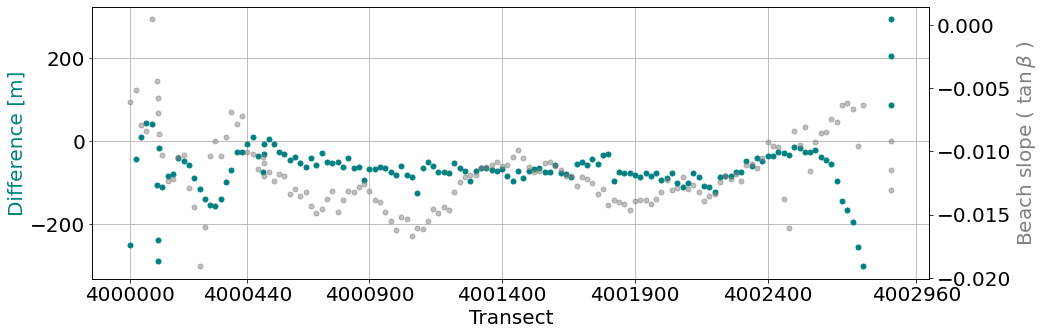

In [7]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(cd_jarkus.index, np.nanmedian(diff, axis=1), '.', markersize=10, color='teal', label='Difference JARKUS - CASSIE')
ax1.set_ylabel('Difference [m]', color='teal')
ax1.set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
ax1.set_xticks(xticks)
ax1.grid()
ax1.ticklabel_format(useOffset=False, style='plain')

ax2 = ax1.twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

# ax1.plot([], [], '.', color='chocolate', markersize=10, label = 'Beach slope')
# ax1.legend()
# # ax2.legend()

In [8]:
# spatial correlation with beach slope
mean_beachslope_interp = np.array(pd.Series(mean_beachslope).interpolate().ffill().bfill())
median_diff_interp = np.array(pd.Series((np.nanmedian(diff, axis=1))).interpolate().ffill().bfill())
np.corrcoef([median_diff_interp, mean_beachslope_interp])

array([[ 1.        , -0.05467036],
       [-0.05467036,  1.        ]])

##### Map

In [9]:
def plot_map(data, cmap, title='', label='', vmin=None, vmax=None):
    import cartopy.crs as ccrs
    import cartopy.io.img_tiles as cimgt
    
    request = cimgt.GoogleTiles(style="satellite")
    # request = cimgt.OSM()

    fig, ax = plt.subplots(figsize=(18,10), subplot_kw=dict(projection=request.crs))
    ax.set_extent([5.1, 5.6, 53.32, 53.49], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, zorder=0, color='lightgrey')
    ax.add_image(request, 11, alpha=0.7, zorder=0)

    # scale the dots according to the values
    # scale = (data - data.min())/(data.max() - data.min())
    # plot = ax.scatter(lon_mean, lat_mean, marker='o', s=100*np.abs(data), c=data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    
    plot = ax.scatter(lon_mean, lat_mean, marker='o', s=100, c=data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    
    plt.colorbar(plot, shrink=1, label=label)
    ax.set_title(title)
    return ax

In [10]:
lon_mean = pickle.load(open(main_datapath_output + 'lon_mean.pkl', 'rb'))
lat_mean = pickle.load(open(main_datapath_output + 'lat_mean.pkl', 'rb'))

<GeoAxes: >

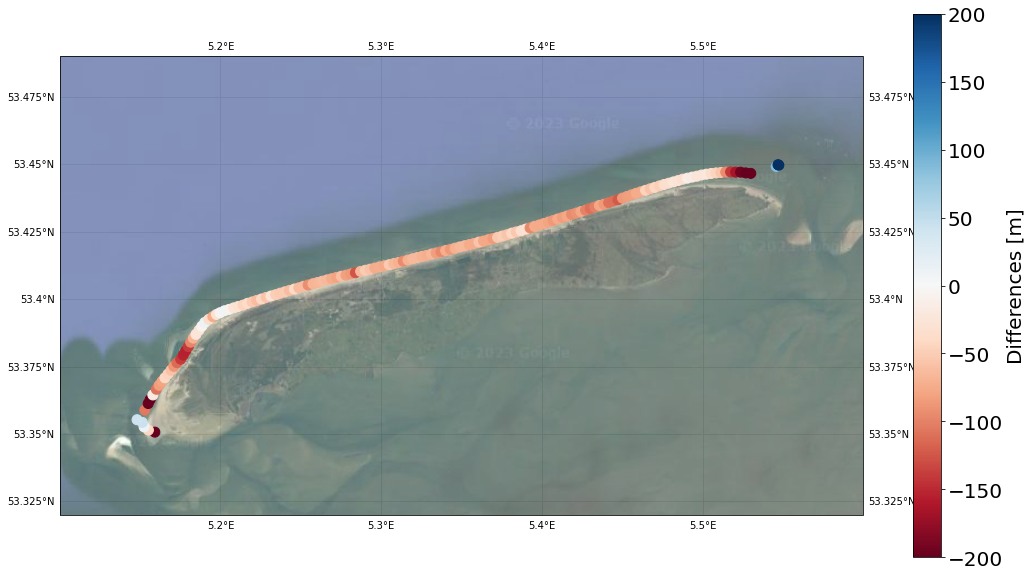

In [11]:
plot_map(np.nanmedian(diff, axis=1), 'RdBu', title='', label='Differences [m]', vmin=-200, vmax=200)

#### Histogram of all differences

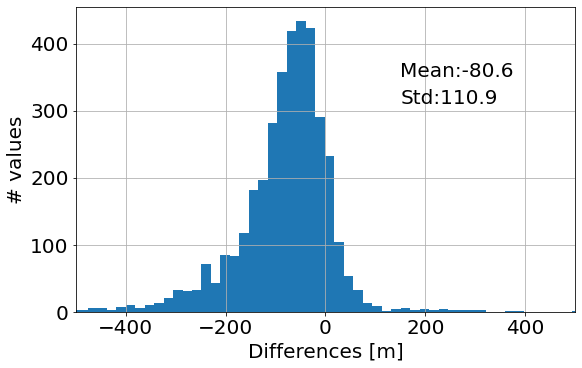

In [12]:
diff_all = np.empty((0))
for x in diff:
    diff_all = np.hstack((diff_all, x))

fig, ax = plt.subplots(figsize=(8, 5))
fig.tight_layout()
ax.hist(diff_all, bins=150)
ax.text(150,350,'Mean:'+str("%.1f" % round(np.nanmean(diff_all),1)), fontsize=20)
ax.text(150,310,'Std:'+str("%.1f" % round(statistics.stdev(diff_all[~np.isnan(diff_all)]),1)), fontsize=20)
ax.set_xlabel('Differences [m]')
ax.set_ylabel('# values')
ax.set_xlim([-500, 500])
ax.grid()

#### Standard deviation per transect

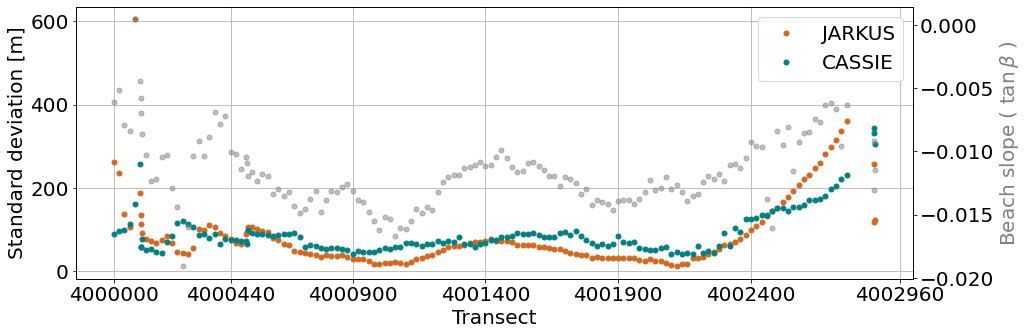

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_jarkus.index, std_jarkus, '.', markersize=10, label='JARKUS', color='chocolate')
ax.plot(cd_jarkus.index, std_cassie, '.', markersize=10, label='CASSIE', color='teal')
ax.legend(loc='upper right')
ax.set_ylabel('Standard deviation [m]')
ax.set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
ax.set_xticks(xticks)
ax.grid()
ax.ticklabel_format(useOffset=False, style='plain')

ax2 = ax.twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

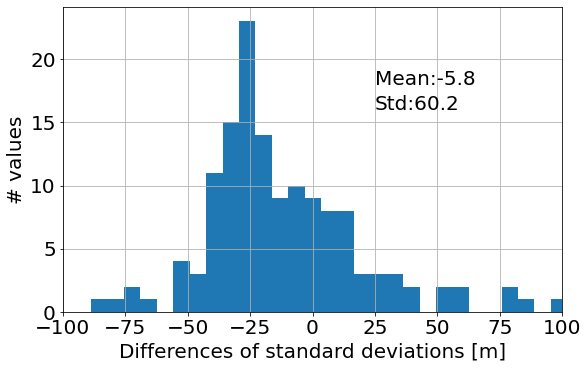

In [14]:
# Differences of standard deviations
std_diff = np.array(std_jarkus) - np.array(std_cassie)

fig, ax = plt.subplots(figsize=(8, 5))
fig.tight_layout()
ax.hist(std_diff, bins=100)
ax.text(25,18,'Mean:'+str("%.1f" % round(np.nanmean(std_diff),1)), fontsize=20)
ax.text(25,16,'Std:'+str("%.1f" % round(statistics.stdev(std_diff[~np.isnan(std_diff)]),1)), fontsize=20)
ax.set_xlabel('Differences of standard deviations [m]')
ax.set_ylabel('# values')
ax.set_xlim([-100, 100])
ax.grid()

#### Trends per transect

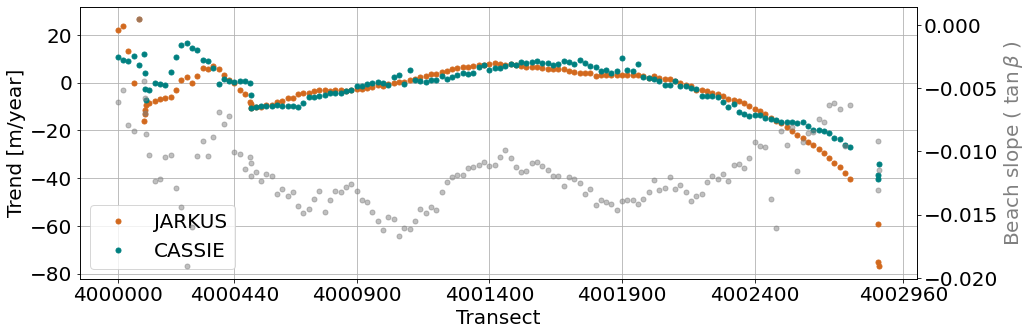

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_jarkus.index, trend_jarkus, '.', markersize=10, label='JARKUS', color='chocolate')
ax.plot(cd_jarkus.index, trend_cassie, '.', markersize=10, label='CASSIE', color='teal')
ax.legend(loc='lower left')
ax.set_ylabel('Trend [m/year]')
ax.set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
ax.set_xticks(xticks)
ax.grid()
ax.ticklabel_format(useOffset=False, style='plain')

ax2 = ax.twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

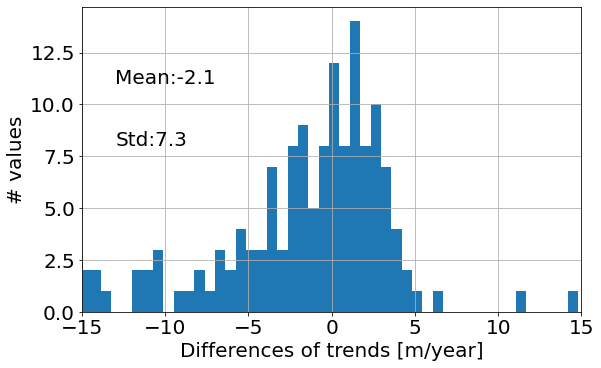

In [16]:
# Differences of trends
trend_diff = np.array(trend_jarkus) - np.array(trend_cassie)

fig, ax = plt.subplots(figsize=(8, 5))
fig.tight_layout()
ax.hist(trend_diff, bins=100)
ax.text(-13,11,'Mean:'+str("%.1f" % round(np.nanmean(trend_diff),1)), fontsize=20)
ax.text(-13,8,'Std:'+str("%.1f" % round(statistics.stdev(trend_diff[~np.isnan(trend_diff)]),1)), fontsize=20)
ax.set_xlabel('Differences of trends [m/year]')
ax.set_ylabel('# values')
ax.set_xlim([-15, 15])
ax.grid()

(-5.0, 5.0)

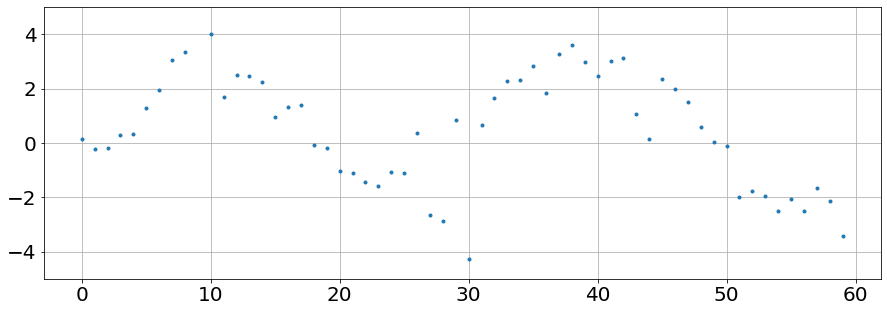

In [17]:
plt.figure(figsize=(15,5))
plt.plot(trend_diff[30:90], '.')
plt.grid()
plt.ylim([-5, 5])

<GeoAxes: >

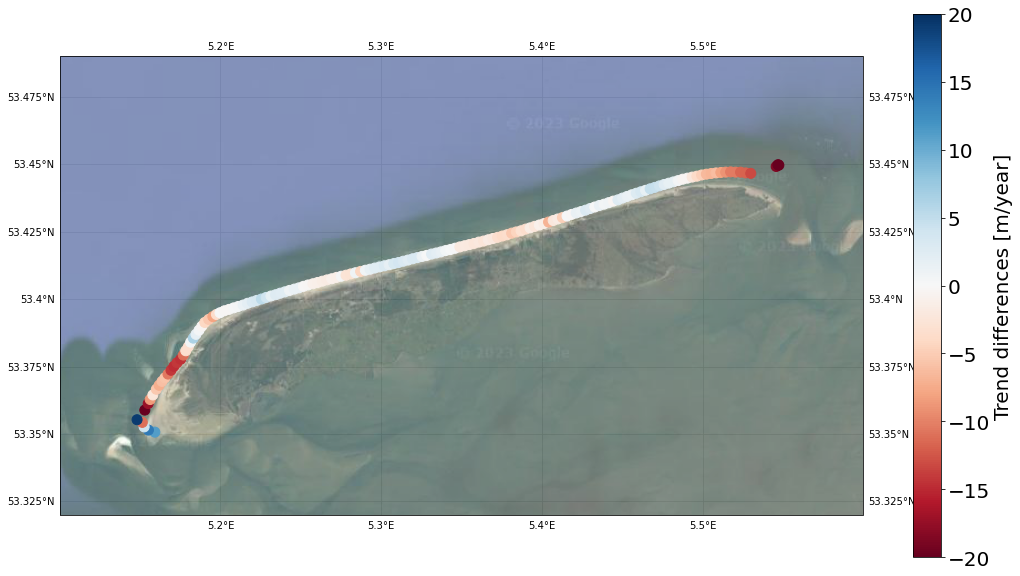

In [18]:
plot_map(trend_diff, 'RdBu', title='', label='Trend differences [m/year]', vmin=-20, vmax=20)

#### Correlation

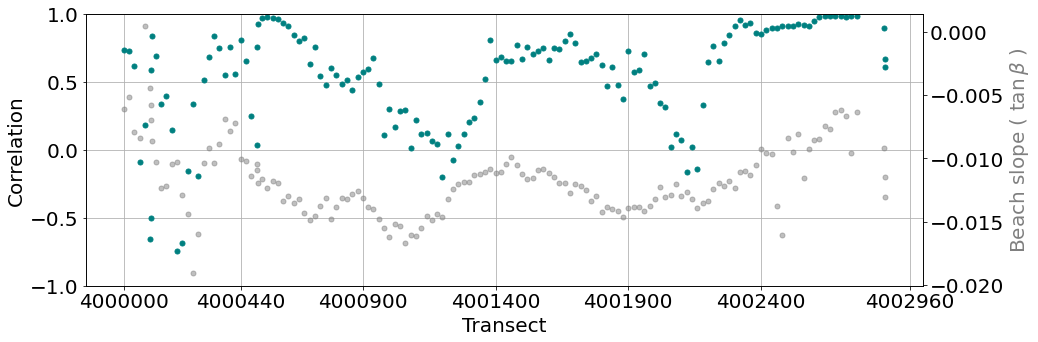

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_jarkus.index, corr, '.', markersize=10, color='teal')
ax.set_ylabel('Correlation')
ax.set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
ax.set_xticks(xticks)
ax.grid()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylim([-1, 1])

ax2 = ax.twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

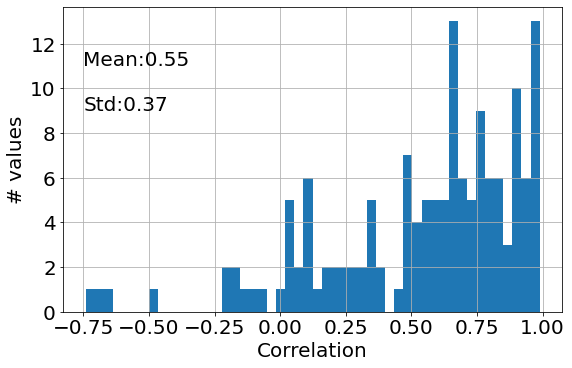

In [20]:
# Correlation
fig, ax = plt.subplots(figsize=(8, 5))
fig.tight_layout()
ax.hist(corr, bins=50)
ax.text(-0.75,11,'Mean:'+str("%.2f" % round(np.nanmean(corr),2)), fontsize=20)
ax.text(-0.75,9,'Std:'+str("%.2f" % round(statistics.stdev(np.array(corr)[~np.isnan(corr)]),2)), fontsize=20)
ax.set_xlabel('Correlation')
ax.set_ylabel('# values')
# ax.set_xlim([-15, 15])
ax.grid()

<GeoAxes: >

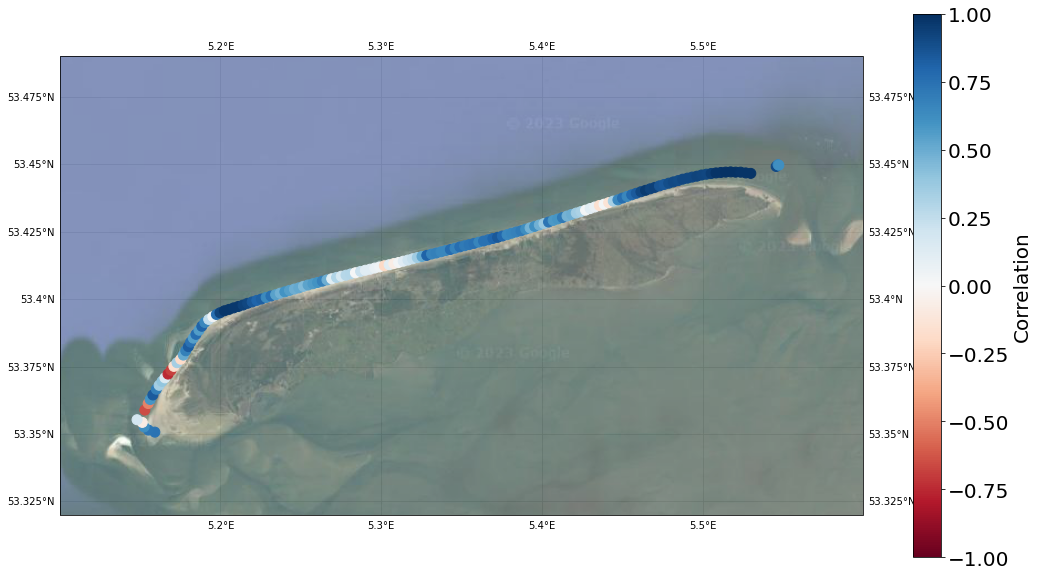

In [21]:
plot_map(corr, 'RdBu', title='', label='Correlation', vmin=-1, vmax=1)

### Combined plot

/home/bene/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


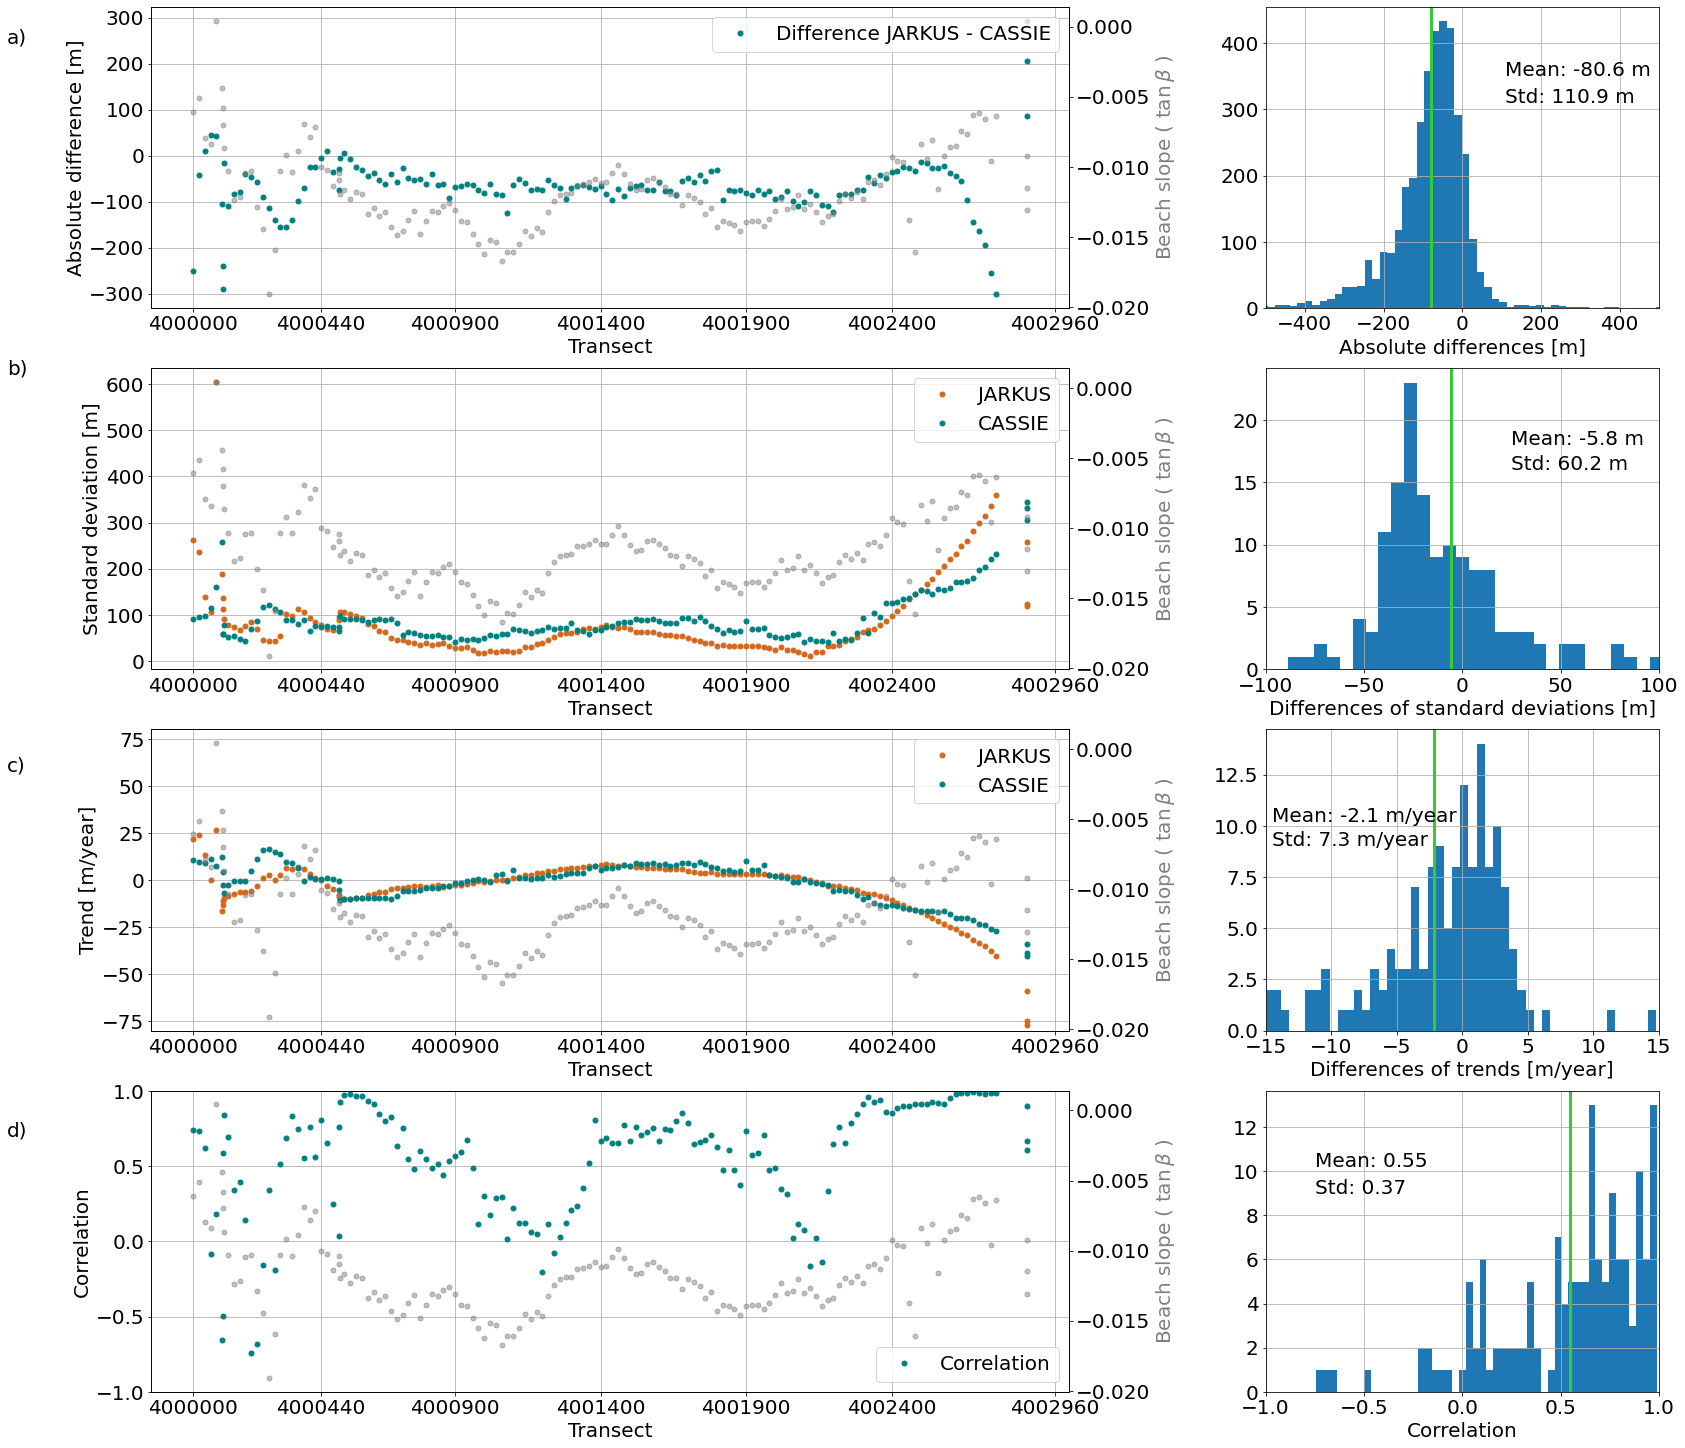

In [22]:
fig, axs = plt.subplots(4,2,figsize=(22,20), width_ratios=[0.7,0.3])
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2)

axs[0,1].text(-3700, 400, 'a)', fontsize=20)
axs[0,1].text(-3700, -100, 'b)', fontsize=20)
axs[0,1].text(-3700, -700, 'c)', fontsize=20)
axs[0,1].text(-3700, -1250, 'd)', fontsize=20)

# Absolute differences
axs[0,0].plot(cd_jarkus.index, np.nanmedian(diff, axis=1), '.', markersize=10, color='teal', label='Difference JARKUS - CASSIE')
axs[0,0].set_ylabel('Absolute difference [m]')
axs[0,0].set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
axs[0,0].set_xticks(xticks)
axs[0,0].grid()
axs[0,0].ticklabel_format(useOffset=False, style='plain')
axs[0,0].legend(loc='upper right')

ax2 = axs[0,0].twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

# Histogram of differences
diff_all = np.empty((0))
for x in diff:
    diff_all = np.hstack((diff_all, x))

axs[0,1].hist(diff_all, bins=150)
axs[0,1].text(110,350,'Mean: '+str("%.1f" % round(np.nanmean(diff_all),1)+' m'), fontsize=20)
axs[0,1].text(110,310,'Std: '+str("%.1f" % round(statistics.stdev(diff_all[~np.isnan(diff_all)]),1)+' m'), fontsize=20)
axs[0,1].axvline(np.nanmean(diff_all), c='limegreen', lw=3)
axs[0,1].set_xlabel('Absolute differences [m]')
axs[0,1].set_xlim([-500, 500])
axs[0,1].grid()

# Standard deviations
axs[1,0].plot(cd_jarkus.index, std_jarkus, '.', markersize=10, label='JARKUS', color='chocolate')
axs[1,0].plot(cd_jarkus.index, std_cassie, '.', markersize=10, label='CASSIE', color='teal')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel('Standard deviation [m]')
axs[1,0].set_xlabel('Transect')
axs[1,0].set_xticks(xticks)
axs[1,0].grid()
axs[1,0].ticklabel_format(useOffset=False, style='plain')

ax2 = axs[1,0].twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

# Differences of standard deviations
std_diff = np.array(std_jarkus) - np.array(std_cassie)

axs[1,1].hist(std_diff, bins=100)
axs[1,1].text(25,18,'Mean: '+str("%.1f" % round(np.nanmean(std_diff),1)+' m'), fontsize=20)
axs[1,1].text(25,16,'Std: '+str("%.1f" % round(statistics.stdev(std_diff[~np.isnan(std_diff)]),1)+' m'), fontsize=20)
axs[1,1].axvline(np.nanmean(std_diff), c='limegreen', lw=3)
axs[1,1].set_xlabel('Differences of standard deviations [m]')
axs[1,1].set_xlim([-100, 100])
axs[1,1].grid()

# Trends
axs[2,0].plot(cd_jarkus.index, trend_jarkus, '.', markersize=10, label='JARKUS', color='chocolate')
axs[2,0].plot(cd_jarkus.index, trend_cassie, '.', markersize=10, label='CASSIE', color='teal')
axs[2,0].legend(loc='upper right')
axs[2,0].set_ylabel('Trend [m/year]')
axs[2,0].set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
axs[2,0].set_xticks(xticks)
axs[2,0].grid()
axs[2,0].ticklabel_format(useOffset=False, style='plain')
axs[2,0].set_ylim([-80, 80])

ax2 = axs[2,0].twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

# Differences of trends
trend_diff = np.array(trend_jarkus) - np.array(trend_cassie)
axs[2,1].hist(trend_diff, bins=100)
axs[2,1].text(-14.5,10.2,'Mean: '+str("%.1f" % round(np.nanmean(trend_diff),1)+' m/year'), fontsize=20)
axs[2,1].text(-14.5,9,'Std: '+str("%.1f" % round(statistics.stdev(trend_diff[~np.isnan(trend_diff)]),1)+' m/year'), fontsize=20)
axs[2,1].axvline(np.nanmean(trend_diff), c='limegreen', lw=3)
axs[2,1].set_xlabel('Differences of trends [m/year]')
axs[2,1].set_xlim([-15, 15])
axs[2,1].grid()

# Correlations
axs[3,0].plot(cd_jarkus.index, corr, '.', markersize=10, color='teal', label='Correlation')
axs[3,0].set_ylabel('Correlation')
axs[3,0].set_xlabel('Transect')
xticks = list(cd_jarkus.index)[0::25]
axs[3,0].set_xticks(xticks)
axs[3,0].grid()
axs[3,0].ticklabel_format(useOffset=False, style='plain')
axs[3,0].set_ylim([-1, 1])
axs[3,0].legend(loc='lower right')

ax2 = axs[3,0].twinx()
ax2.plot(cd_jarkus.index, mean_beachslope, '.', markersize=10, color='grey', alpha=0.5, label='Beach slope')
ax2.set_ylabel(r'Beach slope ( $\tan \beta$ )', color='grey');

# Histogram of correlations
axs[3,1].hist(corr, bins=50)
axs[3,1].text(-0.75,10.2,'Mean: '+str("%.2f" % round(np.nanmean(corr),2)), fontsize=20)
axs[3,1].text(-0.75,9,'Std: '+str("%.2f" % round(statistics.stdev(np.array(corr)[~np.isnan(corr)]),2)), fontsize=20)
axs[3,1].axvline(np.nanmean(corr), c='limegreen', lw=3)
axs[3,1].set_xlabel('Correlation')
axs[3,1].set_xlim([-1,1])
axs[3,1].grid()

plt.savefig('../99_plot_dump/cassie_vs_jarkus_all.png', dpi=dpi, bbox_inches='tight')